In [1]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import learning_curve, GridSearchCV, train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
#from sklearn.grid_search import GridSearchCV   #Perforing grid search
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import math as M


# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

import sys
sys.path.insert(0, '/Users/flywire/Desktop/sci/dihiggsMLProject/')
from utils.commonFunctions import *


In [2]:
def trainBDT_pyswarm(X_train, y_train, X_val, y_val, param):

    evallist = [(X_train, y_train), (X_val, y_val)]
    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train.ravel(), eval_set=evallist, verbose=False, early_stopping_rounds=30)
    best_score = 1.0-model.get_booster().best_score
    return best_score

def f_BDT(x,data,labels):
    # *** 1. split our data set to training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.25, shuffle=True, random_state=7)
    n_particles = x.shape[0]
    BDT_result = []    #used to store the BDT training results for each particle
    for i in range (n_particles):
        # *** 2. set hyper parameters
        param = {
            'n_jobs': -1,
            'eta': 0.3,
            'n_estimators': 5000,
            'max_depth': int(x[i,0]*7+2),
            'min_child_weight': x[i,1],
            'subsample': x[i,2],
            'colsample_bytree': x[i,3],
            'gamma': x[i,4],
            'reg_alpha': x[i,5], 
            'reg_lambda': x[i,6],
            'scale_pos_weight': 1,
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            'random_state': 27
        }
        BDT_result.append(trainBDT_pyswarm(X_train, y_train, X_val, y_val, param))
    return np.array(BDT_result)


In [3]:
# *** 1. Import data and check stuff
testingFraction = 0.3

# *** A. Import Dataset
hh_raw, qcd_raw = importDatasets()


# *** 2. Make mix of dihiggs and QCD for specified variables
#variables = ['deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'hh_mass', 'h1_mass', 'h2_mass','hh_pt', 'h1_pt', 'h2_pt', 'scalarHT']
#variables = ['hh_mass', 'h1_mass', 'h2_mass']
variables = list(qcd_raw.columns.values)
variables.remove('isSignal')
variables.remove('isMatchable')
remove_list = []
for var in variables:
    if((var.find('gen')!=-1) or (var.find('reco')!=-1) or ( (var.find('jet')!=-1) and (var.find('_')!=-1) ) ):
        remove_list.append(var)
#print(remove_list)
for r_var in remove_list:        
    variables.remove(r_var)
    
print(variables)

data_train, data_test, labels_train, labels_test = makeTestTrainSamplesWithUserVariables(hh_raw, qcd_raw, variables, testingFraction)

data_train_norm = scale(data_train)
data_test_norm = scale(data_test)

labels_train_np = labels_train.to_numpy()
labels_test_np = labels_test.to_numpy()


['hh_mass', 'h1_mass', 'h2_mass', 'hh_pt', 'h1_pt', 'h2_pt', 'deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'deltaPhi(h1, h2)', 'deltaPhi(h1 jets)', 'deltaPhi(h2 jets)', 'met', 'met_phi', 'scalarHT', 'nJets', 'nBTags']
N_sig = 78876 , N_bkg = 116481
195357 rows of total data with  195357 labels [Train+Test]
136749 rows of training data with  136749 labels [Train]
58608 rows of testing data with  58608 labels [Test]


In [4]:
from pyswarms.single.global_best import GlobalBestPSO
# *** pyswarm process
# *** 1. set the max and min bound of parameters
param_max_list = [1,5,1,1,1.5,5,3]
param_min_list = [0,0,0,0,0,0,0]
param_max = np.array(param_max_list)
param_min = np.array(param_min_list)
bounds = (param_min, param_max)
# *** 2. set options
#options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9} # can use grid search to get a better value of those parameters
options = {'c1': 2.05, 'c2': 2.05, 'w': 0.7} # try this afterwards
optimizer = GlobalBestPSO(n_particles=50, dimensions=7, options=options, bounds=bounds)
cost, pos = optimizer.optimize(f_BDT, iters=10, data=data_train_norm, labels=labels_train_np)


2019-12-25 20:13:02,229 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/20/Library/Python/3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=0.119
2019-12-26 16:46:23,619 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.11860300000000001, best pos: [0.86476158 3.02731601 0.97628985 0.94066858 0.22290431 4.52482176
 0.51320474]


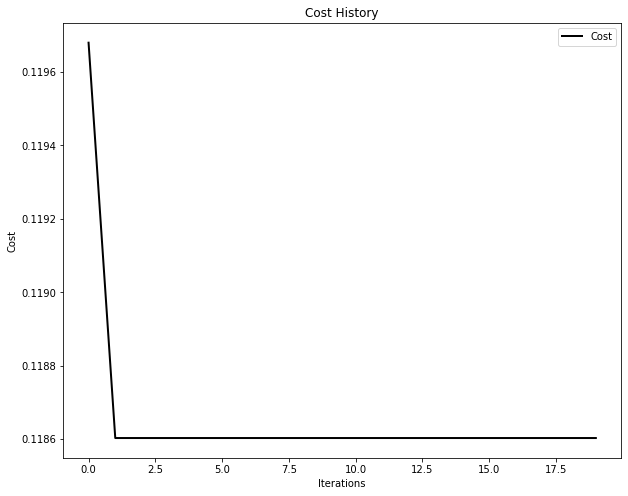

In [5]:
#print(optimizer.pos_history[5])
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()
parameter_name = ['max_depth','min_child_weight','subsample','colsample_bytree','gamma','reg_alpha','reg_lambda']
n_iters = len(optimizer.pos_history) #number of iterations PSO went through
n_dimensions = 7 #number of parameters to tune
n_particles = len(optimizer.pos_history[0]) #number of particles
y_plot = np.zeros((n_dimensions,n_particles*n_iters))
x_plot = np.zeros((n_dimensions,n_particles*n_iters))
plots = []
for i in range (0,n_iters):
    a = optimizer.pos_history[i]
    for d in range(0,n_dimensions):
        x_plot[d,i*n_particles:(i+1)*n_particles] = i+1
        if 0: #d==0 means max_depth, which is normalized
            y_plot[d,i*n_particles:(i+1)*n_particles] = a[:,d]*7+2
        else:
            y_plot[d,i*n_particles:(i+1)*n_particles] = a[:,d]
for nd in range (0,n_dimensions):
    if nd==0:
        plt.scatter(x_plot[nd,:],(y_plot[nd,:]*7+2))
    else:
        plt.scatter(x_plot[nd,:],y_plot[nd,:])
    plt.title(parameter_name[nd])
    plt.show()
    


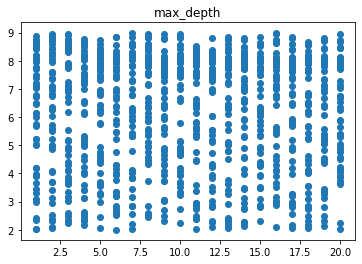

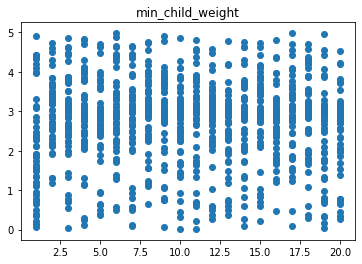

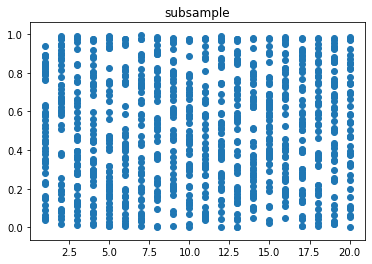

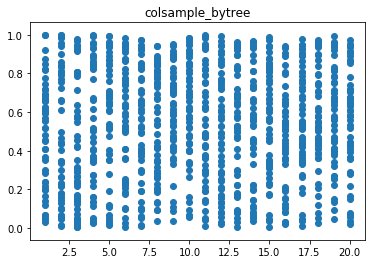

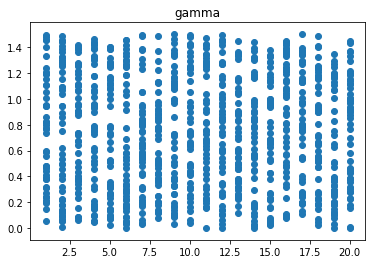

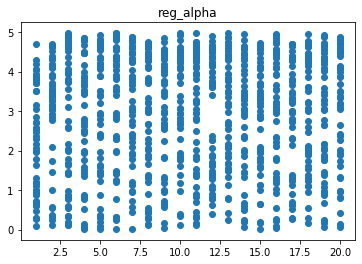

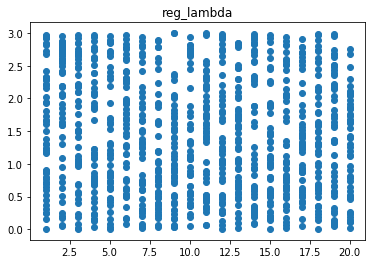

In [6]:
parameter_name = ['max_depth','min_child_weight','subsample','colsample_bytree','gamma','reg_alpha','reg_lambda']
n_iters = len(optimizer.pos_history) #number of iterations PSO went through
n_dimensions = 7 #number of parameters to tune
n_particles = len(optimizer.pos_history[0]) #number of particles
y_plot = np.zeros((n_dimensions,n_particles*n_iters))
x_plot = np.zeros((n_dimensions,n_particles*n_iters))
plots = []
for i in range (0,n_iters):
    a = optimizer.pos_history[i]
    for d in range(0,n_dimensions):
        x_plot[d,i*n_particles:(i+1)*n_particles] = i+1
        if 0: #d==0 means max_depth, which is normalized
            y_plot[d,i*n_particles:(i+1)*n_particles] = a[:,d]*7+2
        else:
            y_plot[d,i*n_particles:(i+1)*n_particles] = a[:,d]
for nd in range (0,n_dimensions):
    if nd==0:
        plt.scatter(x_plot[nd,:],(y_plot[nd,:]*7+2))
    else:
        plt.scatter(x_plot[nd,:],y_plot[nd,:])
    plt.title(parameter_name[nd])
    plt.show()
    

In [35]:
n_iters = len(optimizer.pos_history) #number of iterations PSO went through
n_dimensions = 7 #number of parameters to tune
n_particles = len(optimizer.pos_history[0]) #number of particles
y_plot = np.zeros((n_dimensions,n_particles*n_iters))
x_plot = np.zeros((n_dimensions,n_particles*n_iters))

for d in range(0,n_dimensions):
    a = optimizer.pos_history[i]
    for i in range (0,n_iters):
        x_plot[d,i*n_particles:(i+1)*n_particles] = i+1
        y_plot[d,i*n_particles:(i+1)*n_particles] = a[:,d]
print(y_plot)

    

[[0.77783648 0.50403944 0.94407413 ... 0.38358827 0.32570959 0.79883045]
 [4.4009534  2.53876098 2.73185974 ... 4.47800467 4.48537094 2.92428665]
 [0.13283857 0.17546409 0.90141881 ... 0.33391238 0.78770609 0.60848913]
 ...
 [0.87350736 0.31520685 0.47349006 ... 0.26075282 0.8596351  0.64853861]
 [1.63520612 1.42936279 1.50339874 ... 0.73121503 3.44126622 2.54336913]
 [2.18148507 0.64094123 2.50697821 ... 1.37344522 2.11367445 1.37234844]]


In [ ]:

'''
parameters to tune:
1.max_depth
2.min_child_weight
3.subsample
4.colsample_bytree
5.gamma
6.reg_lambda
7.reg_alpha

param = {
    'eta': 0.1,
    'n_estimator': 5000,
    'max_depth': 11,
    'min_child_weight': 0,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0,
    'reg_alpha': 1, 
    'reg_lambda': 6,
    'scale_pos_weight': 1,
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'random_state': 27
}
'''